In [1]:
%%time
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

import pandas as pd
import wandb
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch


import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Rectangle

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

CPU times: user 2.47 s, sys: 1.53 s, total: 4 s
Wall time: 9.55 s


In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from tempfile import NamedTemporaryFile
import urllib.request as urllib

github_url = "https://github.com/google/fonts/blob/main/apache/robotomono/RobotoMono%5Bwght%5D.ttf"

url = github_url + "?raw=true"  # You want the actual file, not some html

response = urllib.urlopen(url)
f = NamedTemporaryFile(delete=False, suffix=".ttf")
f.write(response.read())
f.close()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Tables

In [188]:
# Table processing
def process_line(means, highlight, highlight_index, highlight_max, ignore_std):
    if highlight:
        if highlight_max:
            tops = set(means.groupby(highlight_index).idxmax())
        else:
            tops = set(means.groupby(highlight_index).idxmin())
    else:
        tops = set()

    def process_line(x):
        if ignore_std:
            if x.name in tops:
                return rf"\textbf{{{x['mean']:0.3f}}}"
            return rf"{x['mean']:0.3f}"
        if x.name in tops:
            return rf"\textbf{{{x['mean']:0.3f} $\pm$ {x['std']:0.3f}}}"
        return rf"{x['mean']:0.3f} $\pm$ {x['std']:0.3f}"

    return process_line


def mean_pm_std(
    data,
    index,
    columns,
    value,
    highlight=True,
    highlight_cols=True,
    highlight_max=True,
    ignore_std=False,
):
    assert len(data) > 0
    groupby = data.groupby([*index, *columns])
    means = groupby.mean()[value].rename("mean")
    stds = groupby.std()[value].rename("std")
    ddf = pd.concat([means, stds], axis=1).T
    highlight_index = columns if highlight_cols else index
    ddf = ddf.apply(
        process_line(means, highlight, highlight_index, highlight_max, ignore_std)
    )
    ddf = ddf.reset_index().pivot(index=index, columns=columns)
    ddf.columns = ddf.columns.droplevel(level=0)
    return ddf


def flatten_dict(d, parent_key="", sep="/"):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def prepare_data(data):
    flattened_data = [flatten_dict(item) for item in data]
    return pd.DataFrame(flattened_data)

In [189]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs(
    "openproblems-comp/DEM-2",
    filters={
        "$and": [
            {
                "tags": {
                    "$in": [
                        "start_resampling_gaussian_v2",
                    ]
                },
                #'group': {'$in': ['5_vars']},
                # "config.data.n_particles": {"$eq": 22},
                #'config.model': {'$eq': model},
                #'config.lr': {'$lt': 1.01 * lr, '$gt': 0.99 * lr},
            }
        ]
    },
)

summary_list, config_list, name_list, tag_list = [], [], [], []
for run in runs:
    tag_list.append(run.tags)
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
    # .name is the human-readable name of the run.
    name_list.append(run.name)
df_summary = prepare_data(summary_list)
df_config = prepare_data(config_list)
tag_list = [str(t) for t in tag_list]
df = pd.concat(
    [
        pd.DataFrame(name_list, columns=["name"]),
        pd.DataFrame(tag_list, columns=["Tags"]),
        df_summary,
        df_config,
    ],
    axis=1,
)

In [198]:
import math


def filterer(x):
    if isinstance(x, float) and not math.isfinite(x):
        return False
    return "table" in list(x)


filtered_df = df[
    ~(
        (df["model/start_resampling_step"].isin([30, 50]))
        | (df["model/annealed_energy/temperature"].isin([0.7, 0.6]))
    )
][
    [
        # "tags",
        "test/temp_annealed/energy_w2",
        "test/temp_annealed/energy_w1",
        "test/temp_annealed/dist_w2",
        "model/annealed_energy/temperature",
        "model/resampling_interval",
        "model/scale_diffusion",
        "model/start_resampling_step",
        "model/resampling_strategy",
        "model/num_eval_samples",
    ]
]


# our w2 metric is w2^2
filtered_df["test/temp_annealed/energy_w2"] = np.sqrt(
    filtered_df["test/temp_annealed/energy_w2"]
)

# also for dist_w2:
filtered_df["test/temp_annealed/dist_w2"] = np.sqrt(
    filtered_df["test/temp_annealed/dist_w2"]
)

In [199]:
renamed_df = filtered_df
# renamed_df = filtered_df.replace(
#     {
#         "src.models.components.tbg.egnn_dynamics_ad2_cat.EGNN_dynamics_AD2_cat": "EQ-CFM",
#         "src.models.components.dit.DIT3D": "DiT-CFM",
#     }
# ).rename(columns={"model/net/_target_": "Model", "data/n_particles": "n_particles"})

In [200]:
mylist = [
    "model/annealed_energy/temperature",
    "model/scale_diffusion",
    "model/resampling_interval",
    # "model/num_eval_samples",
    "model/resampling_strategy",
]

In [201]:
metrics = [
    "test/temp_annealed/energy_w2",
    "test/temp_annealed/energy_w1",
    "test/temp_annealed/dist_w2",
]
df_melt = renamed_df.melt(  # .dropna()
    value_vars=metrics,
    id_vars=mylist,
    var_name="Metric",
)


df_melt.loc[
    df_melt["model/resampling_interval"] == -1, "model/start_resampling_step"
] = 0
df_melt["model/resampling_strategy"] = df_melt["model/resampling_strategy"].fillna(
    "systematic"
)

# drop nan
df_melt = df_melt[df_melt["model/resampling_strategy"] == "systematic"]


df_melt = df_melt.drop(columns=["model/resampling_strategy"])

In [202]:
pd.set_option("display.max_rows", 500)

In [203]:
mylist = [
    "model/annealed_energy/temperature",
    "model/scale_diffusion",
    "model/resampling_interval",
]

results = mean_pm_std(
    df_melt, index=mylist, columns=["Metric"], value="value", highlight_max=False
)
# results.loc[results.index.get_level_values(0) == 1.0]
results

Metric                                                                             test/temp_annealed/dist_w2  \
model/annealed_energy/temperature model/scale_diffusion model/resampling_interval                               
0.8                               False                 -1                                  0.955 $\pm$ 0.008   
                                                         1                                  0.969 $\pm$ 0.008   
                                  True                  -1                                  0.959 $\pm$ 0.003   
                                                         1                                  0.965 $\pm$ 0.010   
0.9                               False                 -1                                  0.928 $\pm$ 0.007   
                                                         1                                  0.928 $\pm$ 0.012   
                                  True                  -1                                  0.924 $\pm$ 0.009   
                                                         1                                  0.929 $\pm$ 0.006   
1.0                               False                 -1                                  0.892 $\pm$ 0.002   
                                                         1                                  0.882 $\pm$ 0.006   
                                  True                  -1                                  0.880 $\pm$ 0.005   
                                                         1                                  0.884 $\pm$ 0.012   
1.2                               False                 -1                                  0.768 $\pm$ 0.005   
                                                         1                                  0.742 $\pm$ 0.001   
                                  True                  -1                                  0.740 $\pm$ 0.003   
                                                         1                                  0.739 $\pm$ 0.005   
1.5                               False                 -1                                  0.471 $\pm$ 0.012   
                                                         1                                  0.474 $\pm$ 0.010   
                                  True                  -1                                  0.464 $\pm$ 0.005   
                                                         1                                  0.466 $\pm$ 0.010   
2.0                               False                 -1                                  0.117 $\pm$ 0.006   
                                                         1                         \textbf{0.117 $\pm$ 0.001}   
                                  True                  -1                                  0.117 $\pm$ 0.004   
                                                         1                                  0.120 $\pm$ 0.007   

Metric                                                                            test/temp_annealed/energy_w1  \
model/annealed_energy/temperature model/scale_diffusion model/resampling_interval                                
0.8                               False                 -1                                  14.521 $\pm$ 0.085   
                                                         1                                   5.268 $\pm$ 0.713   
                                  True                  -1                                   6.211 $\pm$ 0.011   
                                                         1                                   6.438 $\pm$ 0.994   
0.9                               False                 -1                                  13.560 $\pm$ 0.064   
                                                         1                                   4.296 $\pm$ 0.217   
                                  True                  -1                                   5.314 $\pm$ 0.047   
                                   

In [206]:
temp2_melt = df_melt[df_melt["model/annealed_energy/temperature"] == 2.0]
# drop 	model/start_resampling_step column:
temp2_melt = temp2_melt.drop(columns=["model/start_resampling_step"])
# replace cokumn name model/annealed_energy/temperature with temperature
temp2_melt = temp2_melt.rename(
    columns={"model/annealed_energy/temperature": "temperature"}
)
# if metric is test/temp_annealed/energy_w2 replace with energy_w2
temp2_melt = temp2_melt.replace({"test/temp_annealed/energy_w2": "energy_w2"})
temp2_melt = temp2_melt.replace({"test/temp_annealed/energy_w1": "energy_w1"})
temp2_melt = temp2_melt.replace({"test/temp_annealed/dist_w2": "dist_w2"})

# add an sde_type column
temp2_melt["sde_type"] = "SDE"

# if model/scale_diffusion is True and model/resampling_interval is -1 replace sde_type with "tn"
temp2_melt.loc[
    (temp2_melt["model/scale_diffusion"] == True)
    & (temp2_melt["model/resampling_interval"] == -1),
    "sde_type",
] = "tn"

temp2_melt.loc[
    (temp2_melt["model/scale_diffusion"] == True)
    & (temp2_melt["model/resampling_interval"] == 1),
    "sde_type",
] = "tn+fkc"


temp2_melt.loc[
    (temp2_melt["model/scale_diffusion"] == False)
    & (temp2_melt["model/resampling_interval"] == 1),
    "sde_type",
] = "ts+fkc"


temp2_melt.loc[
    (temp2_melt["model/scale_diffusion"] == False)
    & (temp2_melt["model/resampling_interval"] == -1),
    "sde_type",
] = "ts"


temp2_melt = temp2_melt.drop(
    columns=["model/scale_diffusion", "model/resampling_interval"]
)

In [12]:
df_melt_temp1 = df_melt[
    (df_melt["model/annealed_energy/temperature"] == 0.9)
    # | (df_melt["model/annealed_energy/temperature"] == 0.8)
]

# df_melt_temp1.loc[:, "model/resampling_interval"] = df_melt_temp1[
#     "model/resampling_interval"
# ].map({-1: False, 1: True})

In [13]:
# results_temp1

In [13]:
results_temp1 = mean_pm_std(
    df_melt_temp1, index=mylist, columns=["Metric"], value="value", highlight_max=False
)

print(
    results_temp1.to_latex(
        float_format="{:.3f}".format,
    )
)

\begin{tabular}{llllll}
\toprule
 &  & Metric & test/temp_annealed/dist_w2 & test/temp_annealed/energy_w1 & test/temp_annealed/energy_w2 \\
model/annealed_energy/temperature & model/scale_diffusion & model/resampling_interval &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.900000} & \multirow[t]{2}{*}{False} & -1 & 0.861 $\pm$ 0.014 & 13.560 $\pm$ 0.064 & 13.662 $\pm$ 0.068 \\
 &  & 1 & 0.861 $\pm$ 0.021 & 4.296 $\pm$ 0.217 & 4.342 $\pm$ 0.195 \\
\cline{2-6}
 & \multirow[t]{2}{*}{True} & -1 & \textbf{0.853 $\pm$ 0.018} & 5.314 $\pm$ 0.047 & 5.350 $\pm$ 0.049 \\
 &  & 1 & 0.863 $\pm$ 0.011 & \textbf{3.948 $\pm$ 0.235} & \textbf{4.104 $\pm$ 0.253} \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}



### Plotting

In [183]:
df_metric

,temperature,sde_type,Metric,value
0,0.8,ts,energy_w2,15.524403
1,0.8,ts,energy_w2,15.587437
2,0.8,tn,energy_w2,8.775527
3,0.8,tn,energy_w2,8.517219
4,0.8,tn,energy_w2,8.210645
5,0.8,ts+fkc,energy_w2,6.160875
6,0.8,ts+fkc,energy_w2,9.122062
7,0.8,ts+fkc,energy_w2,3.785832
8,0.8,tn+fkc,energy_w2,7.721572
9,0.8,tn+fkc,energy_w2,6.891259


In [233]:
metric = "energy_w1"

# df_metric = df_melt[df_melt["Metric"] == f"test/temp_annealed/energy_{metric}"]
# df_metric = df_melt[df_melt["Metric"] == f"test/temp_annealed/{metric}"]
df_metric = df_melt[df_melt["Metric"] == f"{metric}"]
# grouped_energy_metric = (
#     df_metric.groupby(
#         [
#             "model/annealed_energy/temperature",
#             "model/scale_diffusion",
#             "model/resampling_interval",
#         ]
#     )["value"]
#     .agg(["mean", "std"])
#     .reset_index()
# )
grouped_energy_metric = (
    df_metric.groupby(
        [
            "temperature",
            "sde_type",
        ]
    )["value"]
    .agg(["mean", "std"])
    .reset_index()
)

# grouped_energy_metric["model/resampling_interval"] = grouped_energy_metric[
#     "model/resampling_interval"
# ].map({-1: False, 1: True})

In [234]:
prop = fm.FontProperties(fname=f.name)

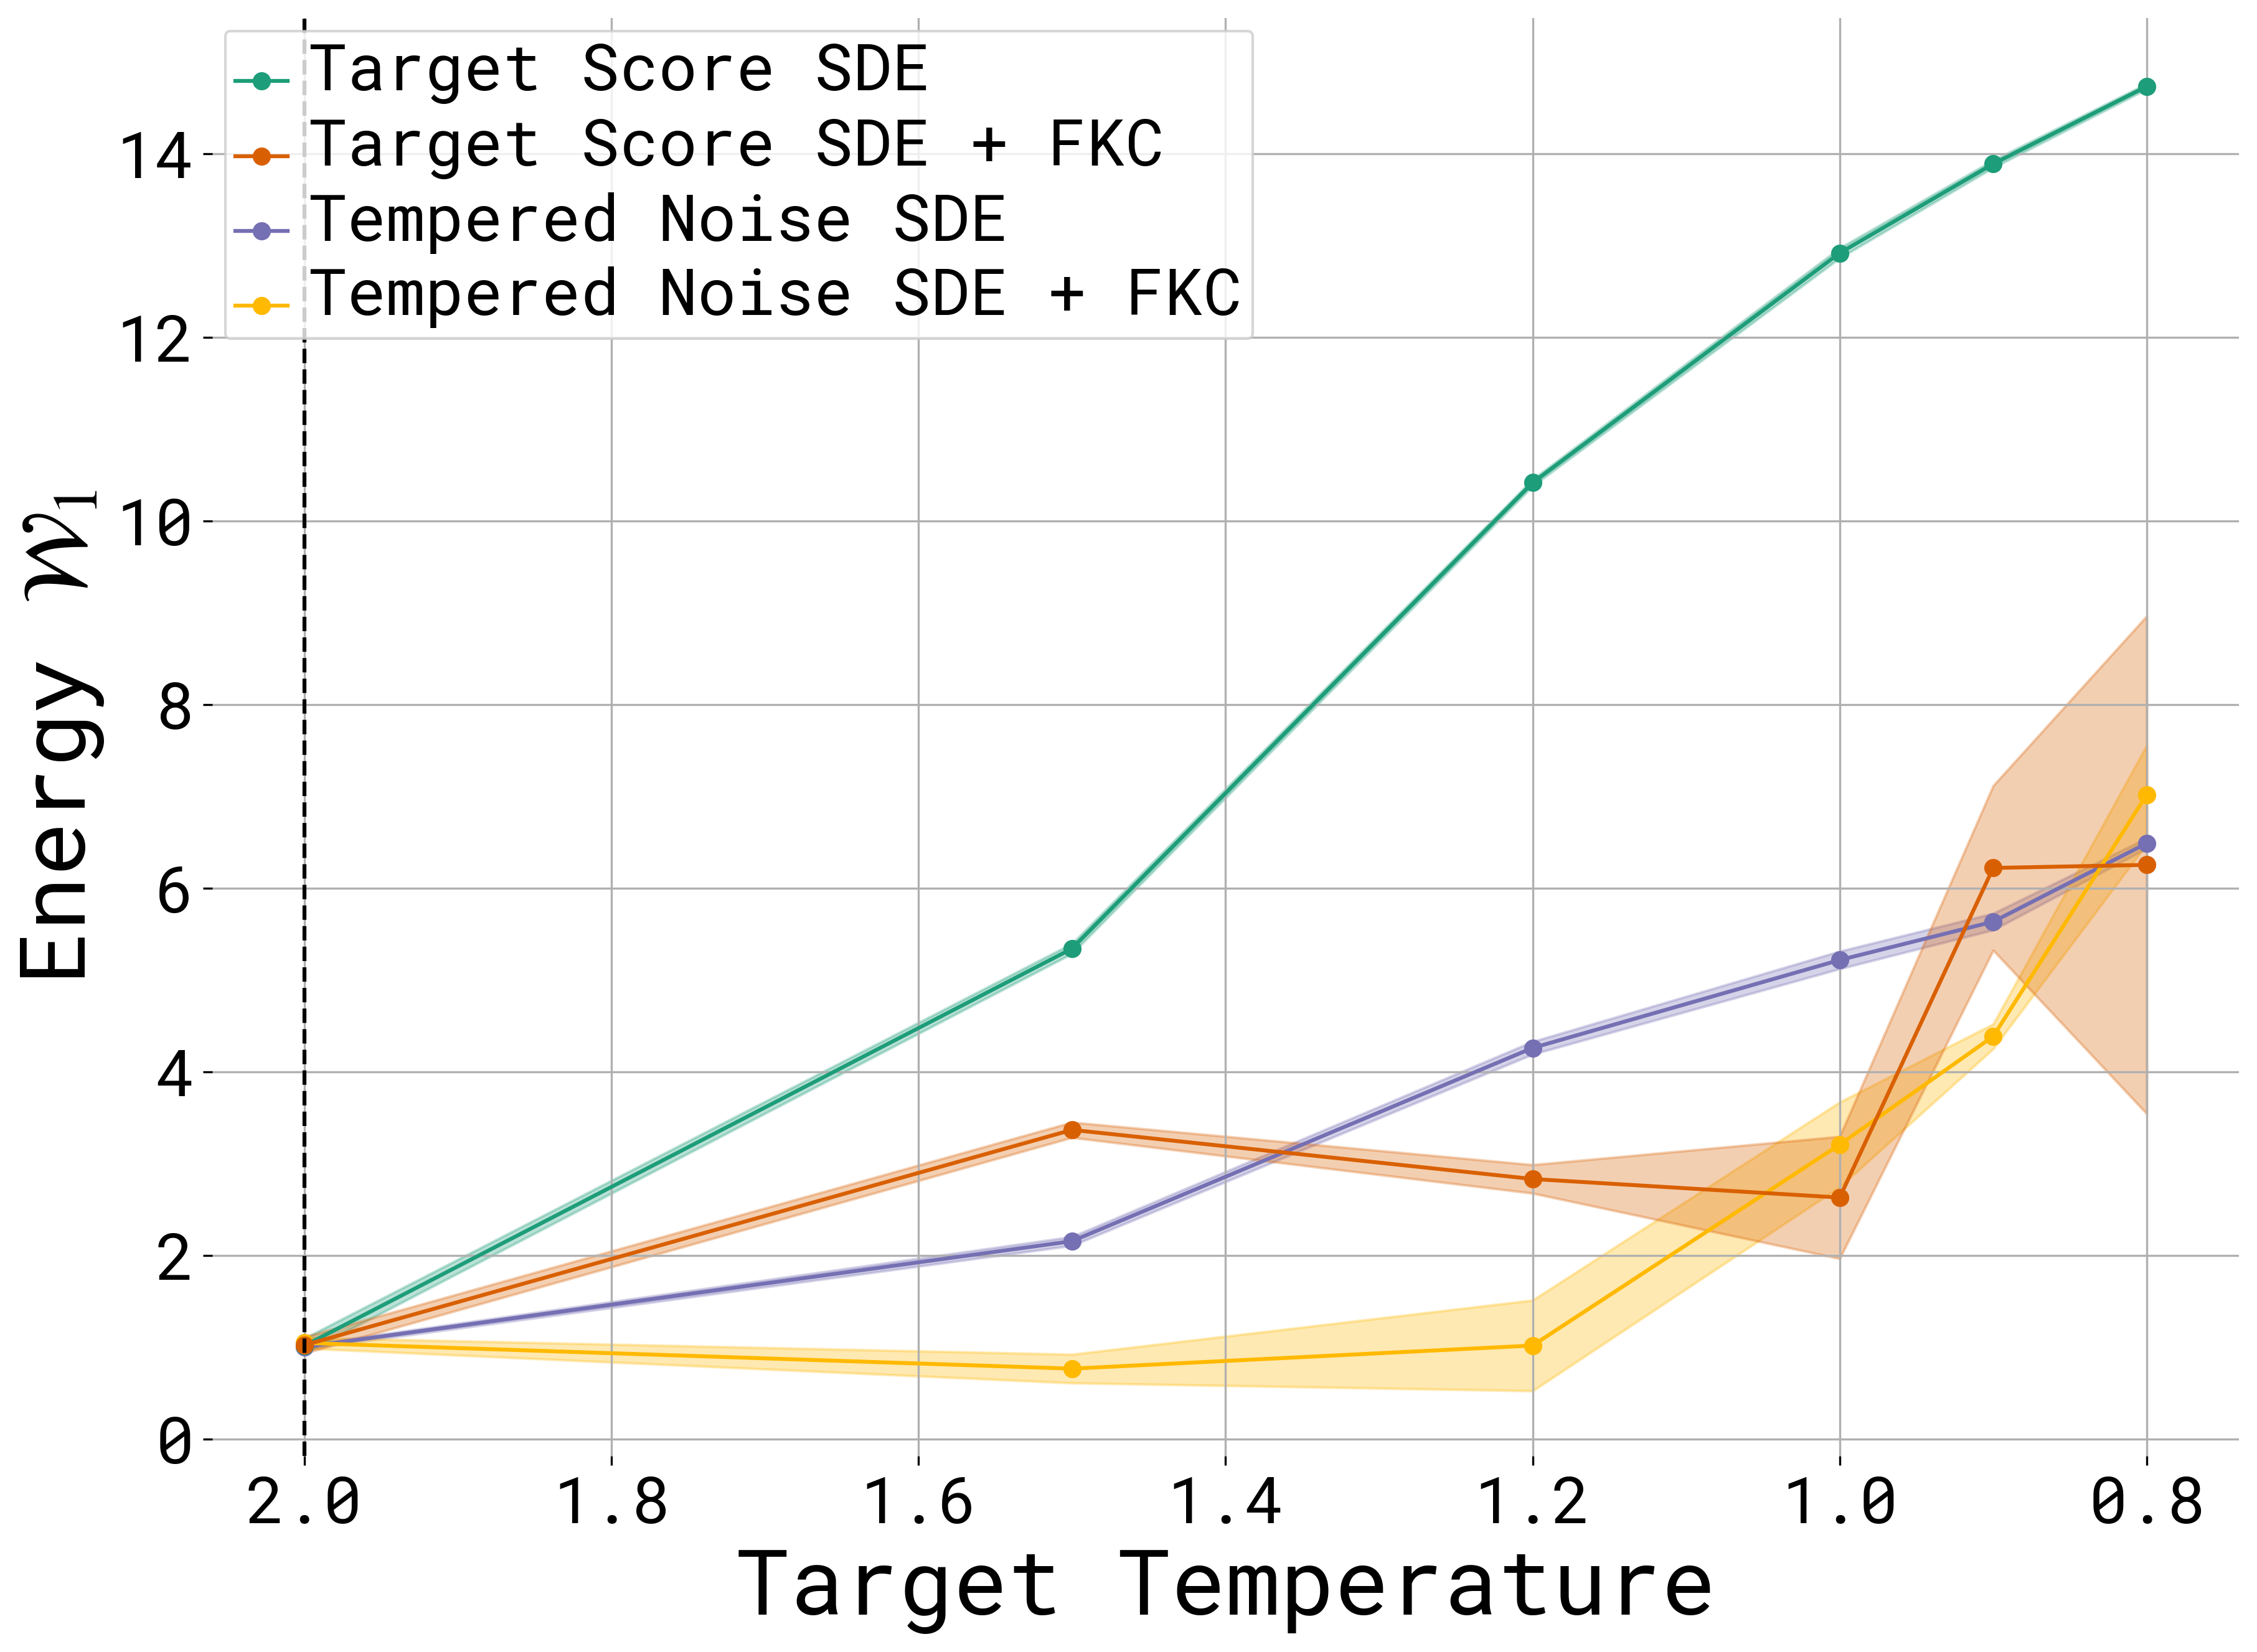

In [255]:
colors = {}
colors["tn"] = "#756FB3"
colors["tn+fkc"] = "#FFB900"
colors["ts"] = "#1D9D79"
colors["ts+fkc"] = "#D96002"

leg_labels = {}
leg_labels["tn"] = "Tempered Noise SDE"
leg_labels["tn+fkc"] = "Tempered Noise SDE + FKC"
leg_labels["ts"] = "Target Score SDE"
leg_labels["ts+fkc"] = "Target Score SDE + FKC"


# Set up the plot
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
fig.patch.set_facecolor("white")

# Iterate over combinations of resampling intervals and scale diffusion values
for i, sde_type in enumerate(grouped_energy_metric["sde_type"].unique()):
    subset = grouped_energy_metric[(grouped_energy_metric["sde_type"] == sde_type)]

    # plot mean and std as a shaded region

    if sde_type == "dem":
        continue

    color = colors[sde_type]
    ax.plot(
        subset["temperature"],
        subset["mean"],
        marker="o",
        linestyle="-",
        label=leg_labels[sde_type],
        color=color,
    )
    ax.fill_between(
        subset["temperature"],
        subset["mean"] - subset["std"],
        subset["mean"] + subset["std"],
        alpha=0.3,
        color=color,
    )


# add vertical line at 2.0
ax.axvline(x=2.0, color="black", linestyle="--", label="Starting Temperature")

# Configure the plot
plt.xlabel("Target Temperature", fontsize=35, fontproperties=prop)

if metric == "energy_w2":
    plt.ylabel(r"Energy $\mathcal{W}_2$", fontsize=35, fontproperties=prop)
elif metric == "energy_w1":
    plt.ylabel(r"Energy $\mathcal{W}_1$", fontsize=35, fontproperties=prop)
else:
    plt.ylabel(
        r"Interatomic Distances $\mathcal{W}_2$", fontsize=35, fontproperties=prop
    )

handles, labels = ax.get_legend_handles_labels()
order = [2, 3, 0, 1]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

# set x ticks size
plt.xticks(fontproperties=prop)
plt.yticks(fontproperties=prop)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


# plt.title("Mean Energy W2 vs Temperature with Standard Deviation")
plt.grid(True)
# plt.legend(fontsize=25)

leg = ax.get_legend()
plt.setp(leg.get_title(), fontproperties=prop, fontsize=25)
plt.setp(leg.get_texts(), fontproperties=prop, fontsize=25)
# reorder legend

ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

plt.gca().invert_xaxis()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.savefig(f"figures/LJ_{metric}_vs_temp.png", bbox_inches="tight")
plt.show()

In [ ]:
# colors = {"#1D9D79", "#756FB3", "#D96002", "#FFB900"}
# # Get unique values for resampling intervals and scale diffusion
# resampling_intervals = sorted(
#     grouped_energy_metric["model/resampling_interval"].unique()
# )
# scale_diffs = sorted(grouped_energy_metric["model/scale_diffusion"].unique())

# # Set up the plot
# fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
# fig.patch.set_facecolor("white")

# # Iterate over combinations of resampling intervals and scale diffusion values
# for ri in resampling_intervals:
#     for sd in scale_diffs:
#         subset = grouped_energy_metric[
#             (grouped_energy_metric["model/resampling_interval"] == ri)
#             & (grouped_energy_metric["model/scale_diffusion"] == sd)
#         ]

#         # plot mean and std as a shaded region

#         if not sd:
#             leg = "Target Score SDE"
#         elif sd:
#             leg = "Tempered Noise SDE"

#         if ri:
#             leg += f" + FKC"

#         color = colors.pop()
#         ax.plot(
#             subset["model/annealed_energy/temperature"],
#             subset["mean"],
#             marker="o",
#             linestyle="-",
#             label=leg,
#             color=color,
#         )
#         ax.fill_between(
#             subset["model/annealed_energy/temperature"],
#             subset["mean"] - subset["std"],
#             subset["mean"] + subset["std"],
#             alpha=0.3,
#             color=color,
#         )


# # add vertical line at 2.0
# ax.axvline(x=2.0, color="black", linestyle="--", label="Starting Temperature")

# # Configure the plot
# plt.xlabel("Target Temperature", fontsize=35, fontproperties=prop)

# if metric == "energy_w2":
#     plt.ylabel(r"Energy $\mathcal{W}_2$", fontsize=35, fontproperties=prop)
# elif metric == "energy_w1":
#     plt.ylabel(r"Energy $\mathcal{W}_1$", fontsize=35, fontproperties=prop)
# else:
#     plt.ylabel(
#         r"Interatomic Distances $\mathcal{W}_2$", fontsize=35, fontproperties=prop
#     )

# plt.legend()

# # set x ticks size
# plt.xticks(fontproperties=prop)
# plt.yticks(fontproperties=prop)

# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)


# # plt.title("Mean Energy W2 vs Temperature with Standard Deviation")
# plt.grid(True)
# # plt.legend(fontsize=25)

# leg = ax.get_legend()
# plt.setp(leg.get_title(), fontproperties=prop, fontsize=25)
# plt.setp(leg.get_texts(), fontproperties=prop, fontsize=25)

# ax.xaxis.set_minor_locator(NullLocator())
# ax.yaxis.set_minor_locator(NullLocator())

# plt.gca().invert_xaxis()

# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
# ax.spines["left"].set_visible(False)
# plt.savefig(f"figures/LJ_{metric}_vs_temp.png", bbox_inches="tight")
# plt.show()

### Plot Generated Samples

In [14]:
annealed_samples_path = {}
dem_samples_path = {}

In [240]:
annealed_samples_path["tn", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_19-04-11/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["ts", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["tn+fkc", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["ts+fkc", 0.8] = [
    # for target score fkc # Comment the bottom 2 for plotting
    # "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/1/samples_temperature_0.8_10240.pt",
    # "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/1/samples_temperature_0.8_10240.pt",
    # target fkc, 30, rare glass:
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-30_12-09-01/1/samples_temperature_0.8_10240.pt",
]

In [16]:
# annealed_samples_path[0.7] = [
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/0/samples_temperature_0.7_10240.pt",
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/0/samples_temperature_0.7_10240.pt",
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_23-14-35/0/samples_temperature_0.7_10240.pt",
# ]

annealed_samples_path["ts", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/2/samples_temperature_0.9_10240.pt",
]
annealed_samples_path["tn", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_19-04-11/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/2/samples_temperature_0.9_10240.pt",
]
annealed_samples_path["ts+fkc", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/2/samples_temperature_0.9_10240.pt",
]

annealed_samples_path["tn+fkc", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/2/samples_temperature_0.9_10240.pt",
]

In [17]:
annealed_samples_path["ts", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/3/samples_temperature_1.0_10240.pt",
]
annealed_samples_path["tn", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/3/samples_temperature_1.0_10240.pt",
]

annealed_samples_path["ts+fkc", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/3/samples_temperature_1.0_10240.pt",
]

annealed_samples_path["tn+fkc", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/3/samples_temperature_1.0_10240.pt",
]

In [18]:
annealed_samples_path["ts", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/4/samples_temperature_1.2_10240.pt",
]
annealed_samples_path["tn", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/4/samples_temperature_1.2_10240.pt",
]

annealed_samples_path["ts+fkc", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/4/samples_temperature_1.2_10240.pt",
]

annealed_samples_path["tn+fkc", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/4/samples_temperature_1.2_10240.pt",
]

In [19]:
annealed_samples_path["tn", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/5/samples_temperature_1.5_10240.pt",
]

annealed_samples_path["ts", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/5/samples_temperature_1.5_10240.pt",
]

annealed_samples_path["ts+fkc", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/5/samples_temperature_1.5_10240.pt",
]


annealed_samples_path["tn+fkc", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/5/samples_temperature_1.5_10240.pt",
]

In [158]:
dem_samples_path[0.7] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-30_00-25-06/samples_temperature_0.7_10240.pt"
]

dem_samples_path[0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_15-51-17/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-30_15-54-33/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-30_16-22-55/samples_temperature_0.8_10240.pt",
]

dem_samples_path[0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_17-40-19/samples_temperature_0.9_10240.pt"
]

dem_samples_path[1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_16-38-31/samples_temperature_1.0_10240.pt"
]

dem_samples_path[1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_19-35-03/samples_temperature_1.2_10240.pt"
]

dem_samples_path[1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_23-09-45/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-30_15-24-00/samples_temperature_1.5_10240.pt",
]

In [278]:
temperature = 0.8

if temperature == 0.8:
    sde_type = "ts+fkc"
else:
    sde_type = "tn+fkc"

annealed_samples = []
for path in annealed_samples_path[sde_type, temperature]:
    samples = torch.load(path, weights_only=True)
    annealed_samples.append(samples)
annealed_samples = torch.cat(annealed_samples)

dem_samples = []
for path in dem_samples_path[temperature]:
    samples = torch.load(path, weights_only=True)
    dem_samples.append(samples)
dem_samples = torch.cat(dem_samples)

In [279]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles

from src.energies.lennardjones_energy import LennardJonesEnergy

target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path="../../data/",
    smooth=False,
    temperature=temperature,
)

In [280]:
from src.models.components.utils import sample_from_tensor


num_samples = 10000
test_samples = target.sample_test_set(num_samples)
test_energy = target(test_samples)
test_dist = target.interatomic_dist(test_samples).reshape(-1)


dem_samples = sample_from_tensor(dem_samples, num_samples)
dem_energy = target(dem_samples)
dem_dist = target.interatomic_dist(dem_samples).reshape(-1)

annealed_samples = sample_from_tensor(annealed_samples, num_samples)
annealed_energy = target(annealed_samples)
annealed_dist = target.interatomic_dist(annealed_samples).reshape(-1)

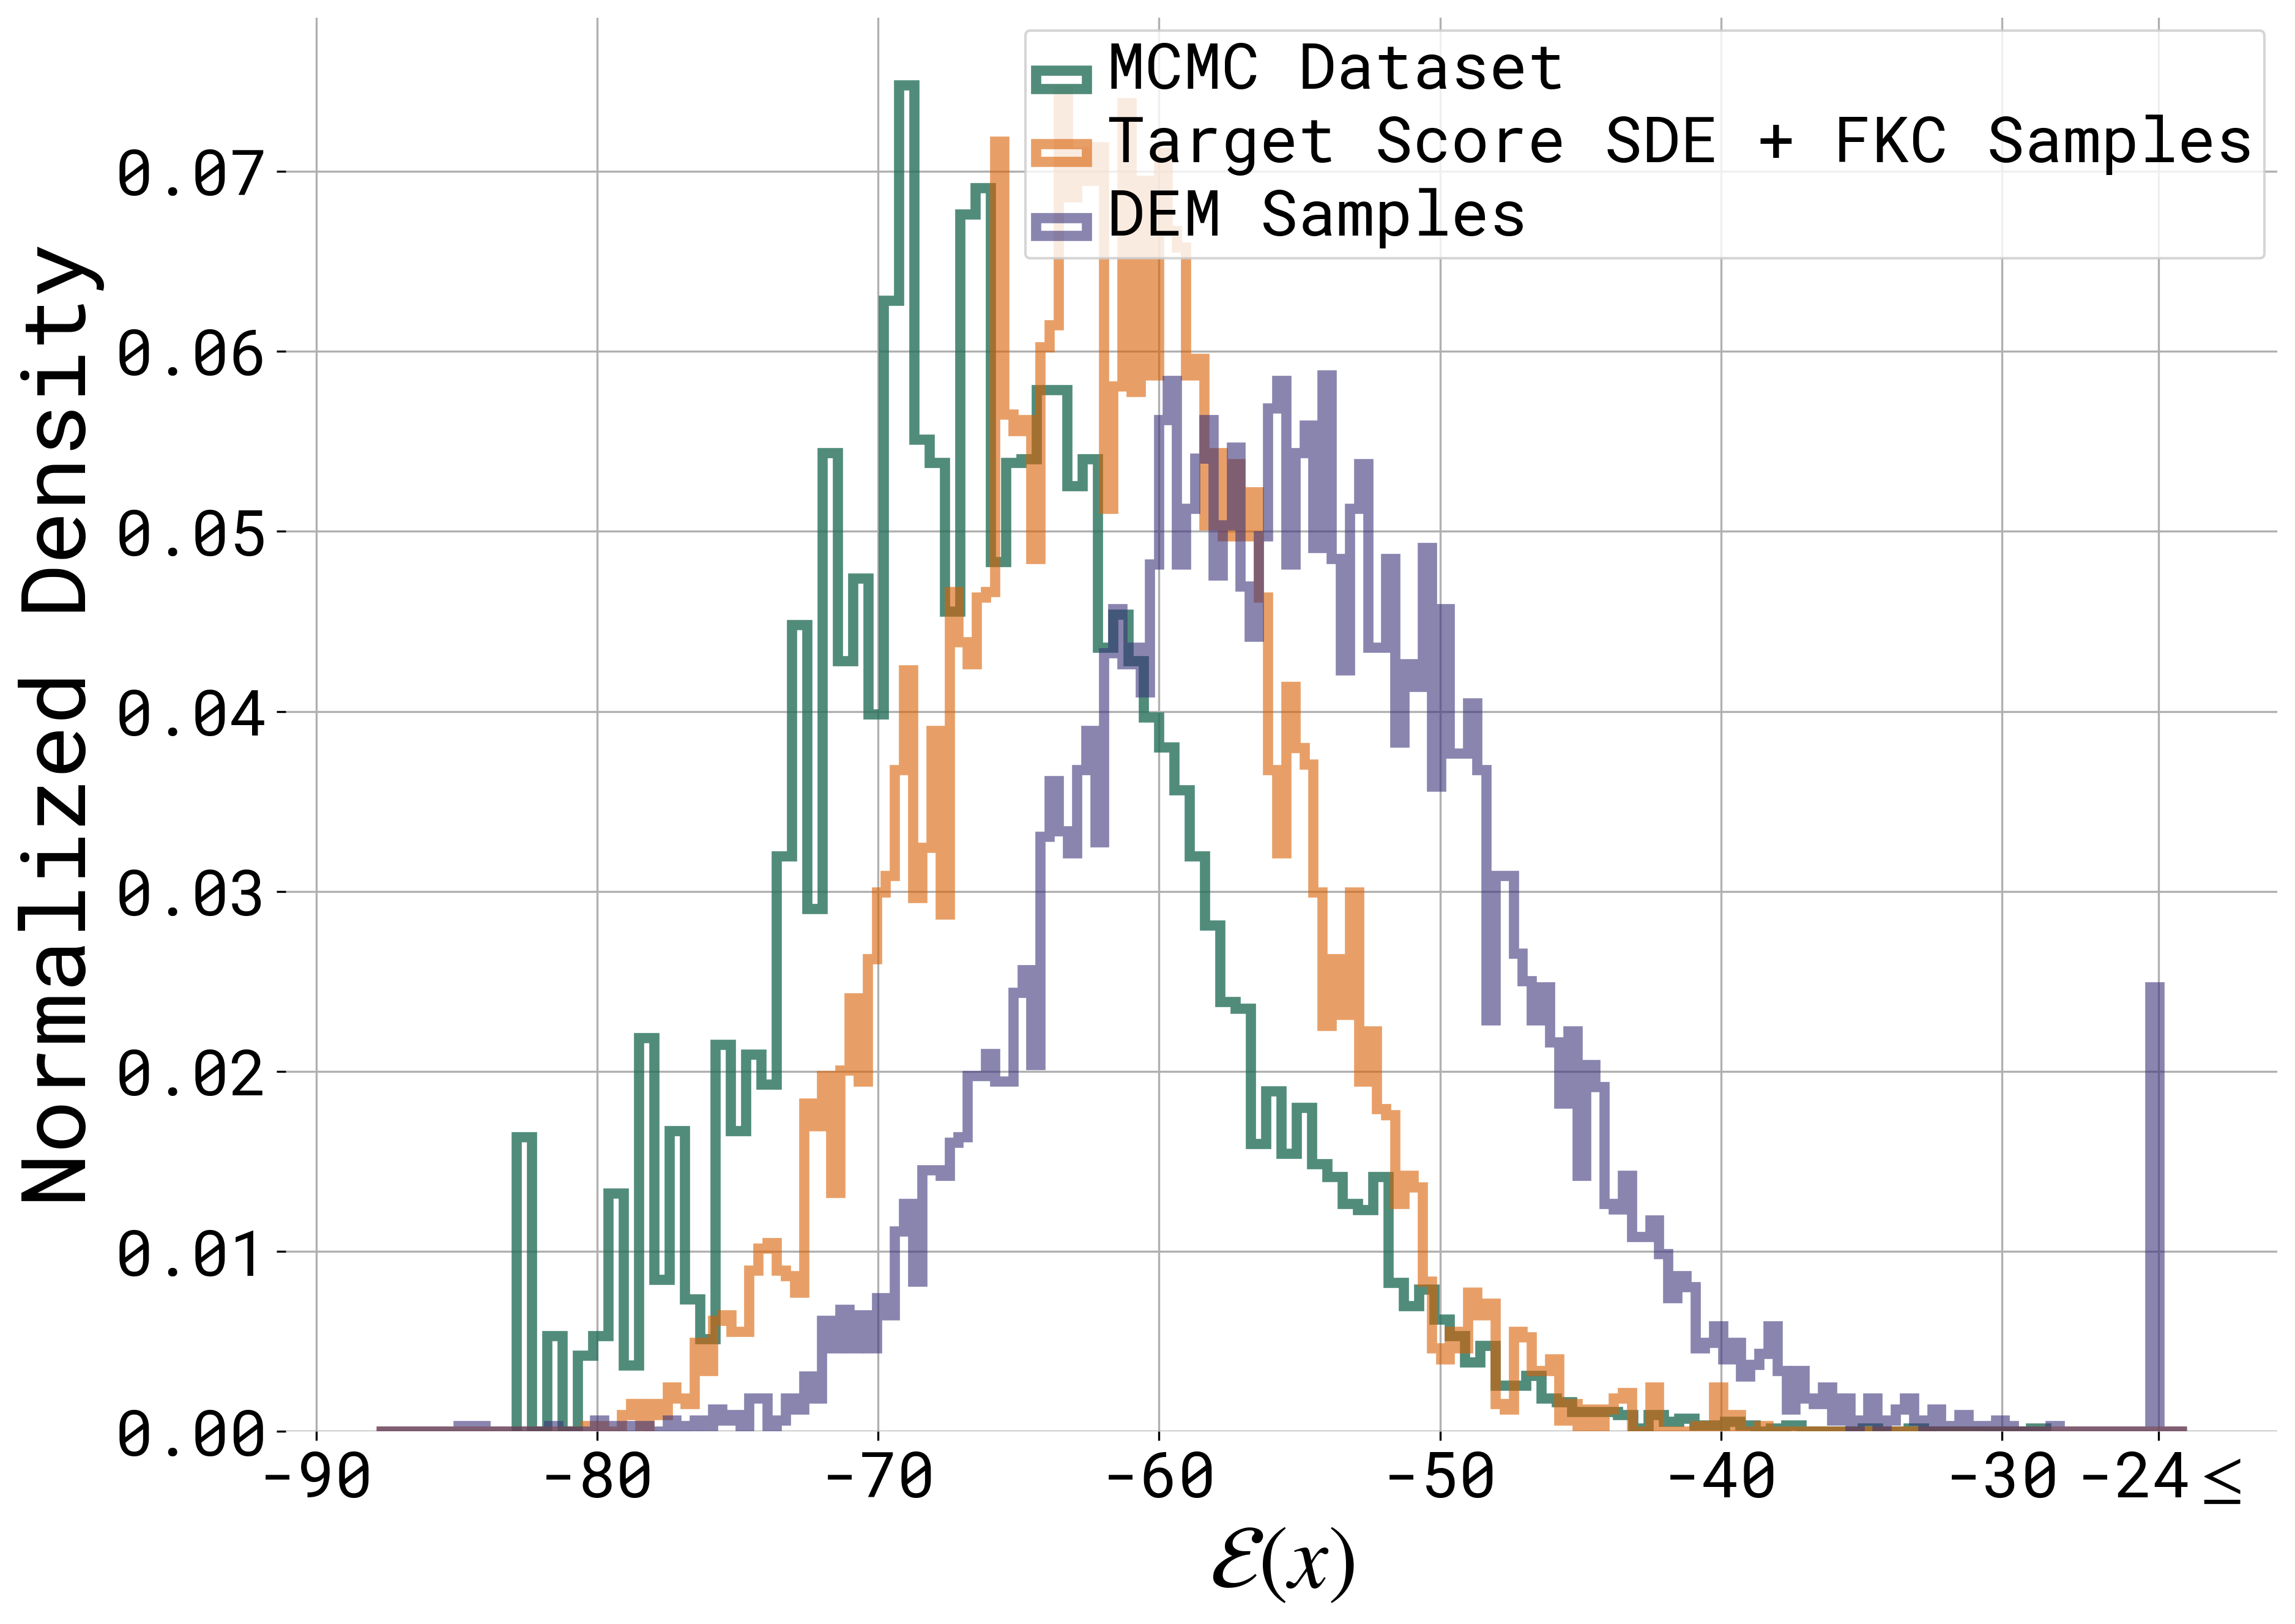

In [281]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
fig.patch.set_facecolor("white")


# bin_edges = np.linspace(-90, -30, 200)
min_bin = (-test_energy).min().item()
max_bin = (-test_energy).max().item()
bin_edges = np.linspace(min_bin - 5, max_bin + 5, 200)


_, bins, _ = ax.hist(
    -test_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.8,
    color="#256F5A",
    histtype="step",
    linewidth=4,
    label="MCMC Dataset",
)

ax.hist(
    -annealed_energy.detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color=colors[sde_type],
    histtype="step",
    linewidth=4,
    label=[leg_labels[sde_type] + " Samples"],
)


ax.hist(
    torch.clip(-dem_energy, max=bin_edges[-1] - 1).detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color="#3B347B",
    histtype="step",
    linewidth=4,
    label="DEM Samples",
)


xticks = list(ax.get_xticks())
xticks = xticks[1:-1]

# Add a new xtick (e.g., at x=5) with custom label
new_tick = bin_edges[-1] - 1
custom_label = f"{new_tick:.0f}" + r"$\leq$"

# Update xticks and labels
xticks.append(new_tick)
xtick_labels = [str(int(tick)) if tick != new_tick else custom_label for tick in xticks]

# Set new xticks and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=30, fontproperties=prop)


plt.xlabel(r"$\mathcal{E}(x)$", fontsize=35, fontproperties=prop)
plt.ylabel("Normalized Density", fontsize=35, fontproperties=prop)
plt.legend()


for label in ax.get_xticklabels():
    label.set_fontproperties(prop)
plt.yticks(fontproperties=prop)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

leg = ax.get_legend()
plt.setp(leg.get_title(), fontproperties=prop, fontsize=25)
plt.setp(leg.get_texts(), fontproperties=prop, fontsize=25)

plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.savefig(f"figures/LJ_samples_temp_{temperature}.png", bbox_inches="tight")
plt.show()

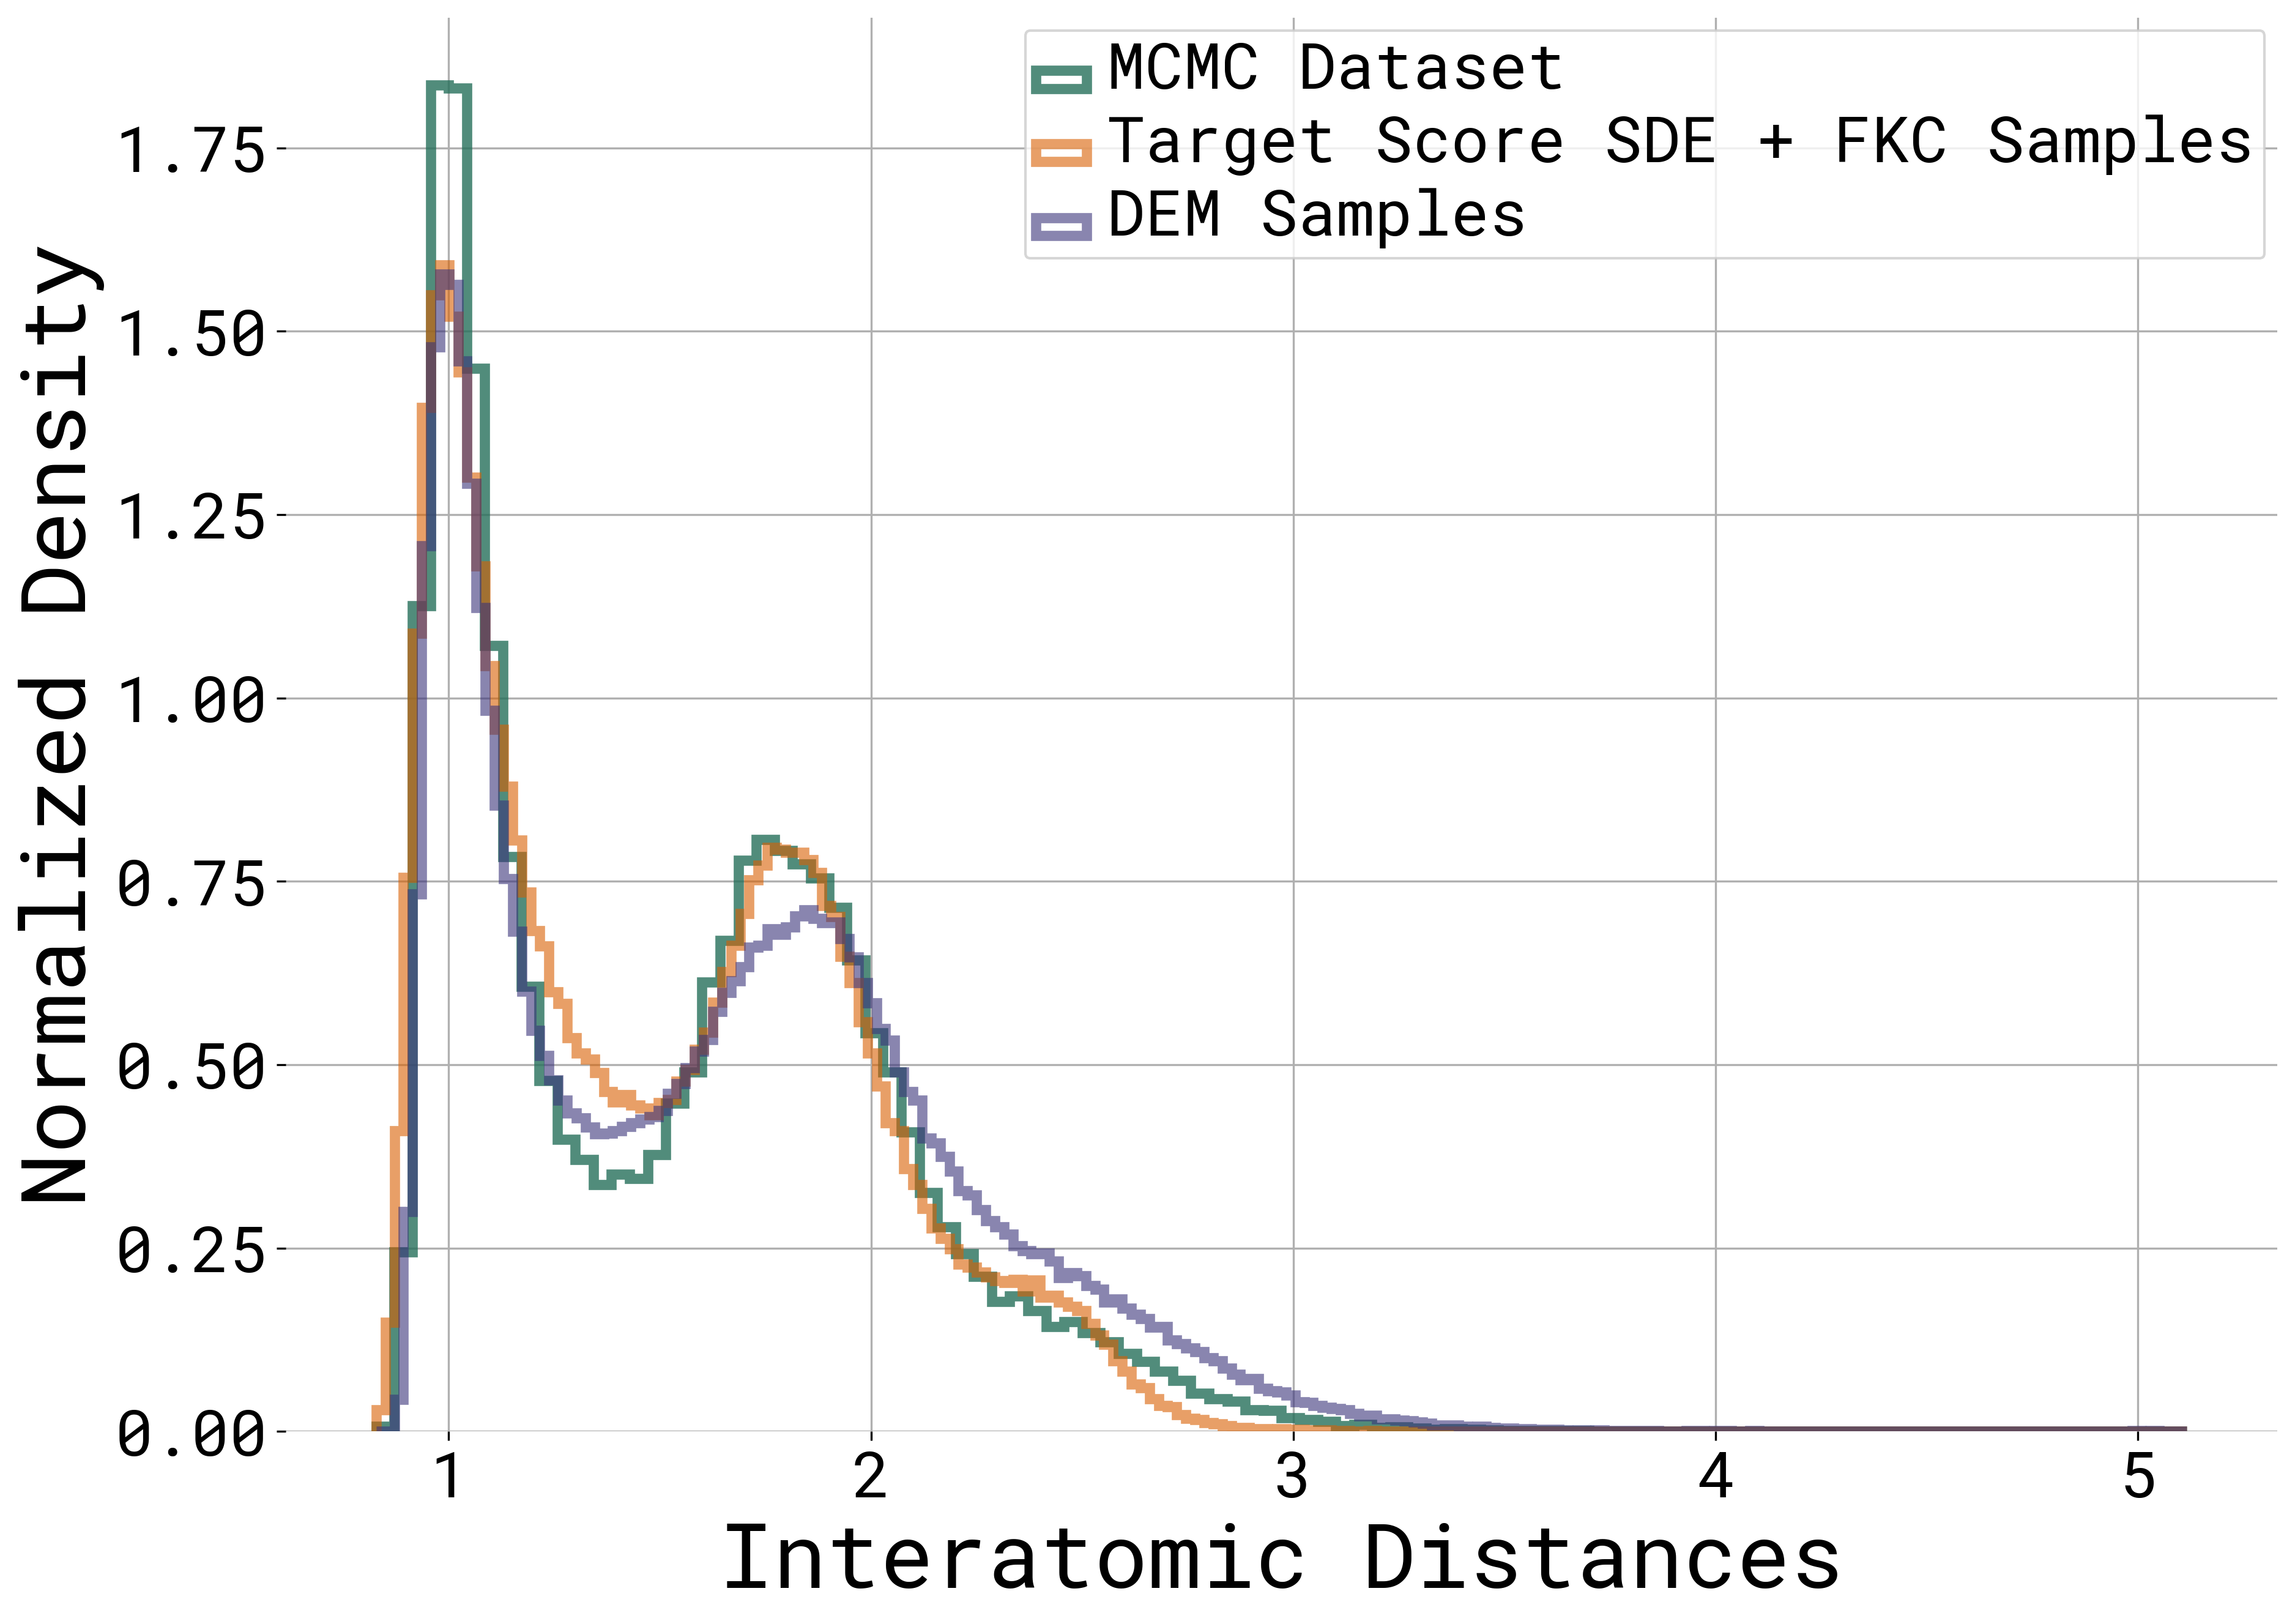

In [282]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
fig.patch.set_facecolor("white")

# bin_edges = np.linspace(-90, -30, 200)
min_bin = (test_dist).min().item()
max_bin = (test_dist).max().item()
bin_edges = np.linspace(min_bin, max_bin, 200)


_, bins, _ = ax.hist(
    test_dist.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.8,
    color="#256F5A",
    histtype="step",
    linewidth=4,
    label="MCMC Dataset",
)

ax.hist(
    annealed_dist.detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color=colors[sde_type],
    histtype="step",
    linewidth=4,
    label=[leg_labels[sde_type] + " Samples"],
)


ax.hist(
    dem_dist.detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color="#3B347B",
    histtype="step",
    linewidth=4,
    label="DEM Samples",
)


# add xtick at bin_edges[-1] - 1
# plt.xticks([bin_edges[-1] - 1])

plt.xlabel("Interatomic Distances", fontsize=35, fontproperties=prop)
plt.ylabel("Normalized Density", fontsize=35, fontproperties=prop)
plt.legend()


plt.xticks(fontproperties=prop)
plt.yticks(fontproperties=prop)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

leg = ax.get_legend()
plt.setp(leg.get_title(), fontproperties=prop, fontsize=25)
plt.setp(leg.get_texts(), fontproperties=prop, fontsize=25)

plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.savefig(f"figures/LJ_samples_temp_{temperature}_dist.png", bbox_inches="tight")
plt.show()

In [300]:
num_samples = 10000

data = []

for i, temp in enumerate([0.8, 0.9, 1.0, 1.2, 1.5]):

    annealed_samples = {}
    annealed_energy = {}
    annealed_dist = {}
    energy_w2 = {}
    energy_w1 = {}
    dist_w2 = {}

    target = LennardJonesEnergy(
        dimensionality=dimensionality,
        n_particles=n_particles,
        device=device,
        data_path="../../data/",
        smooth=False,
        temperature=temp,
    )

    test_samples = target.sample_test_set(num_samples)
    test_energy = target(test_samples)
    test_dist = target.interatomic_dist(test_samples).reshape(-1)

    for sde_type in ["ts", "tn", "ts+fkc", "tn+fkc", "dem"]:
        if sde_type == "dem":
            paths = dem_samples_path[temp]
        else:
            paths = annealed_samples_path[sde_type, temp]
        for j, path in enumerate(paths):
            s = torch.load(path, weights_only=True)
            e = target(s)
            mask = e < -100

            print(temp, mask.sum(), sde_type)
            s = s[~mask]
            e = e[~mask]
            d = target.interatomic_dist(s).reshape(-1)

            energy_w2 = (
                pot.emd2_1d(
                    test_energy.cpu().numpy(), e.cpu().numpy(), check_marginals=False
                )
                ** 0.5
            )
            energy_w1 = pot.emd2_1d(
                test_energy.cpu().numpy(),
                e.cpu().numpy(),
                metric="euclidean",
                check_marginals=False,
            )
            dist_w2 = (
                pot.emd2_1d(
                    test_dist.cpu().numpy(), d.cpu().numpy(), check_marginals=False
                )
                ** 0.5
            )

            data.append([temp, sde_type, energy_w2, energy_w1, dist_w2])

0.8 tensor(224, device='cuda:0') ts
0.8 tensor(222, device='cuda:0') ts
0.8 tensor(217, device='cuda:0') tn
0.8 tensor(220, device='cuda:0') tn
0.8 tensor(222, device='cuda:0') tn
0.8 tensor(0, device='cuda:0') ts+fkc
0.8 tensor(0, device='cuda:0') tn+fkc
0.8 tensor(0, device='cuda:0') tn+fkc
0.8 tensor(0, device='cuda:0') tn+fkc
0.8 tensor(240, device='cuda:0') dem
0.8 tensor(0, device='cuda:0') dem
0.8 tensor(0, device='cuda:0') dem
0.9 tensor(217, device='cuda:0') ts
0.9 tensor(217, device='cuda:0') ts
0.9 tensor(214, device='cuda:0') tn
0.9 tensor(222, device='cuda:0') tn
0.9 tensor(0, device='cuda:0') ts+fkc
0.9 tensor(0, device='cuda:0') ts+fkc
0.9 tensor(0, device='cuda:0') tn+fkc
0.9 tensor(0, device='cuda:0') tn+fkc
0.9 tensor(0, device='cuda:0') tn+fkc
0.9 tensor(240, device='cuda:0') dem
1.0 tensor(224, device='cuda:0') ts
1.0 tensor(219, device='cuda:0') ts
1.0 tensor(224, device='cuda:0') tn
1.0 tensor(225, device='cuda:0') tn
1.0 tensor(0, device='cuda:0') ts+fkc
1.0 tens

In [166]:
metrics_all = pd.DataFrame(
    data,
    columns=[
        "temperature",
        "sde_type",
        "energy_w2",
        "energy_w1",
        "dist_w2",
    ],
)

In [208]:
metrics = [
    "energy_w2",
    "energy_w1",
    "dist_w2",
]
df_melt = metrics_all.melt(  # .dropna()
    value_vars=metrics,
    id_vars=["temperature", "sde_type"],
    var_name="Metric",
)

In [209]:
# append temp2_melt to df_melt
df_melt = pd.concat([df_melt, temp2_melt])

In [168]:
mylist = [
    "temperature",
    "sde_type",
]

results = mean_pm_std(
    df_melt, index=mylist, columns=["Metric"], value="value", highlight=False
)
# results.loc[results.index.get_level_values(0) == 1.0]
results

Metric                          dist_w2           energy_w1  \
temperature sde_type                                          
0.8         dem       0.103 $\pm$ 0.001   9.794 $\pm$ 0.100   
            tn        0.108 $\pm$ 0.007   6.487 $\pm$ 0.056   
            tn+fkc    0.047 $\pm$ 0.006   7.016 $\pm$ 0.538   
            ts        0.189 $\pm$ 0.002  14.730 $\pm$ 0.029   
            ts+fkc    0.048 $\pm$ 0.019   6.252 $\pm$ 2.710   
0.9         dem         0.168 $\pm$ nan    14.516 $\pm$ nan   
            tn        0.110 $\pm$ 0.016   5.633 $\pm$ 0.090   
            tn+fkc    0.042 $\pm$ 0.004   4.384 $\pm$ 0.135   
            ts        0.215 $\pm$ 0.001  13.886 $\pm$ 0.040   
            ts+fkc    0.042 $\pm$ 0.009   6.218 $\pm$ 0.896   
1.0         dem         0.127 $\pm$ nan     1.352 $\pm$ nan   
            tn        0.094 $\pm$ 0.002   5.215 $\pm$ 0.095   
            tn+fkc    0.053 $\pm$ 0.008   3.205 $\pm$ 0.462   
            ts        0.221 $\pm$ 0.001  12.915 $\pm$ 0.054   
            ts+fkc    0.039 $\pm$ 0.008   2.629 $\pm$ 0.665   
1.2         dem         0.143 $\pm$ nan     9.669 $\pm$ nan   
            tn        0.098 $\pm$ 0.002   4.258 $\pm$ 0.069   
            tn+fkc    0.076 $\pm$ 0.006   1.017 $\pm$ 0.494   
            ts        0.234 $\pm$ 0.004  10.414 $\pm$ 0.036   
            ts+fkc    0.026 $\pm$ 0.001   2.831 $\pm$ 0.155   
1.5         dem       0.268 $\pm$ 0.005   4.471 $\pm$ 0.105   
            tn        0.095 $\pm$ 0.006   2.154 $\pm$ 0.048   
            tn+fkc    0.066 $\pm$ 0.002   0.765 $\pm$ 0.156   
            ts        0.168 $\pm$ 0.009   5.340 $\pm$ 0.054   
            ts+fkc    0.083 $\pm$ 0.003   3.366 $\pm$ 0.083   

Metric                         energy_w2  
temperature sde_type                      
0.8         dem        9.804 $\pm$ 0.101  
            tn         8.501 $\pm$ 0.283  
            tn+fkc     7.111 $\pm$ 0.535  
            ts        15.556 $\pm$ 0.045  
            ts+fkc     6.356 $\pm$ 2.673  
0.9         dem         14.606 $\pm$ nan  
            tn         7.682 $\pm$ 0.585  
            tn+fkc     4.530 $\pm$ 0.167  
            ts        14.893 $\pm$ 0.012  
            ts+fkc     6.259 $\pm$ 0.873  
1.0         dem          2.050 $\pm$ nan  
            tn         6.560 $\pm$ 0.000  
            tn+fkc     3.538 $\pm$ 0.468  
            ts        13.558 $\pm$ 0.112  
            ts+fkc     2.876 $\pm$ 0.548  
1.2         dem          9.736 $\pm$ nan  
            tn         5.564 $\pm$ 0.095  
            tn+fkc     1.300 $\pm$ 0.433  
            ts        10.910 $\pm$ 0.110  
            ts+fkc     2.915 $\pm$ 0.074  
1.5         dem        5.211 $\pm$ 0.017  
            tn         3.920 $\pm$ 0.258  
            tn+fkc     0.939 $\pm$ 0.171  
            ts         6.210 $\pm$ 0.254  
            ts+fkc     3.386 $\pm$ 0.090

In [169]:
print(
    results.to_latex(
        float_format="{:.3f}".format,
    )
)

\begin{tabular}{lllll}
\toprule
 & Metric & dist_w2 & energy_w1 & energy_w2 \\
temperature & sde_type &  &  &  \\
\midrule
\multirow[t]{5}{*}{0.800000} & dem & 0.103 $\pm$ 0.001 & 9.794 $\pm$ 0.100 & 9.804 $\pm$ 0.101 \\
 & tn & 0.108 $\pm$ 0.007 & 6.487 $\pm$ 0.056 & 8.501 $\pm$ 0.283 \\
 & tn+fkc & 0.047 $\pm$ 0.006 & 7.016 $\pm$ 0.538 & 7.111 $\pm$ 0.535 \\
 & ts & 0.189 $\pm$ 0.002 & 14.730 $\pm$ 0.029 & 15.556 $\pm$ 0.045 \\
 & ts+fkc & 0.048 $\pm$ 0.019 & 6.252 $\pm$ 2.710 & 6.356 $\pm$ 2.673 \\
\cline{1-5}
\multirow[t]{5}{*}{0.900000} & dem & 0.168 $\pm$ nan & 14.516 $\pm$ nan & 14.606 $\pm$ nan \\
 & tn & 0.110 $\pm$ 0.016 & 5.633 $\pm$ 0.090 & 7.682 $\pm$ 0.585 \\
 & tn+fkc & 0.042 $\pm$ 0.004 & 4.384 $\pm$ 0.135 & 4.530 $\pm$ 0.167 \\
 & ts & 0.215 $\pm$ 0.001 & 13.886 $\pm$ 0.040 & 14.893 $\pm$ 0.012 \\
 & ts+fkc & 0.042 $\pm$ 0.009 & 6.218 $\pm$ 0.896 & 6.259 $\pm$ 0.873 \\
\cline{1-5}
\multirow[t]{5}{*}{1.000000} & dem & 0.127 $\pm$ nan & 1.352 $\pm$ nan & 2.050 $\pm$ nan 

In [283]:
def load_and_sample_data(sde_type, temp, num_samples):
    annealed_samples = []
    for path in annealed_samples_path[sde_type, temp]:
        samples = torch.load(path, weights_only=True)
        annealed_samples.append(samples)

    annealed_samples = torch.cat(annealed_samples)
    return sample_from_tensor(annealed_samples, num_samples)

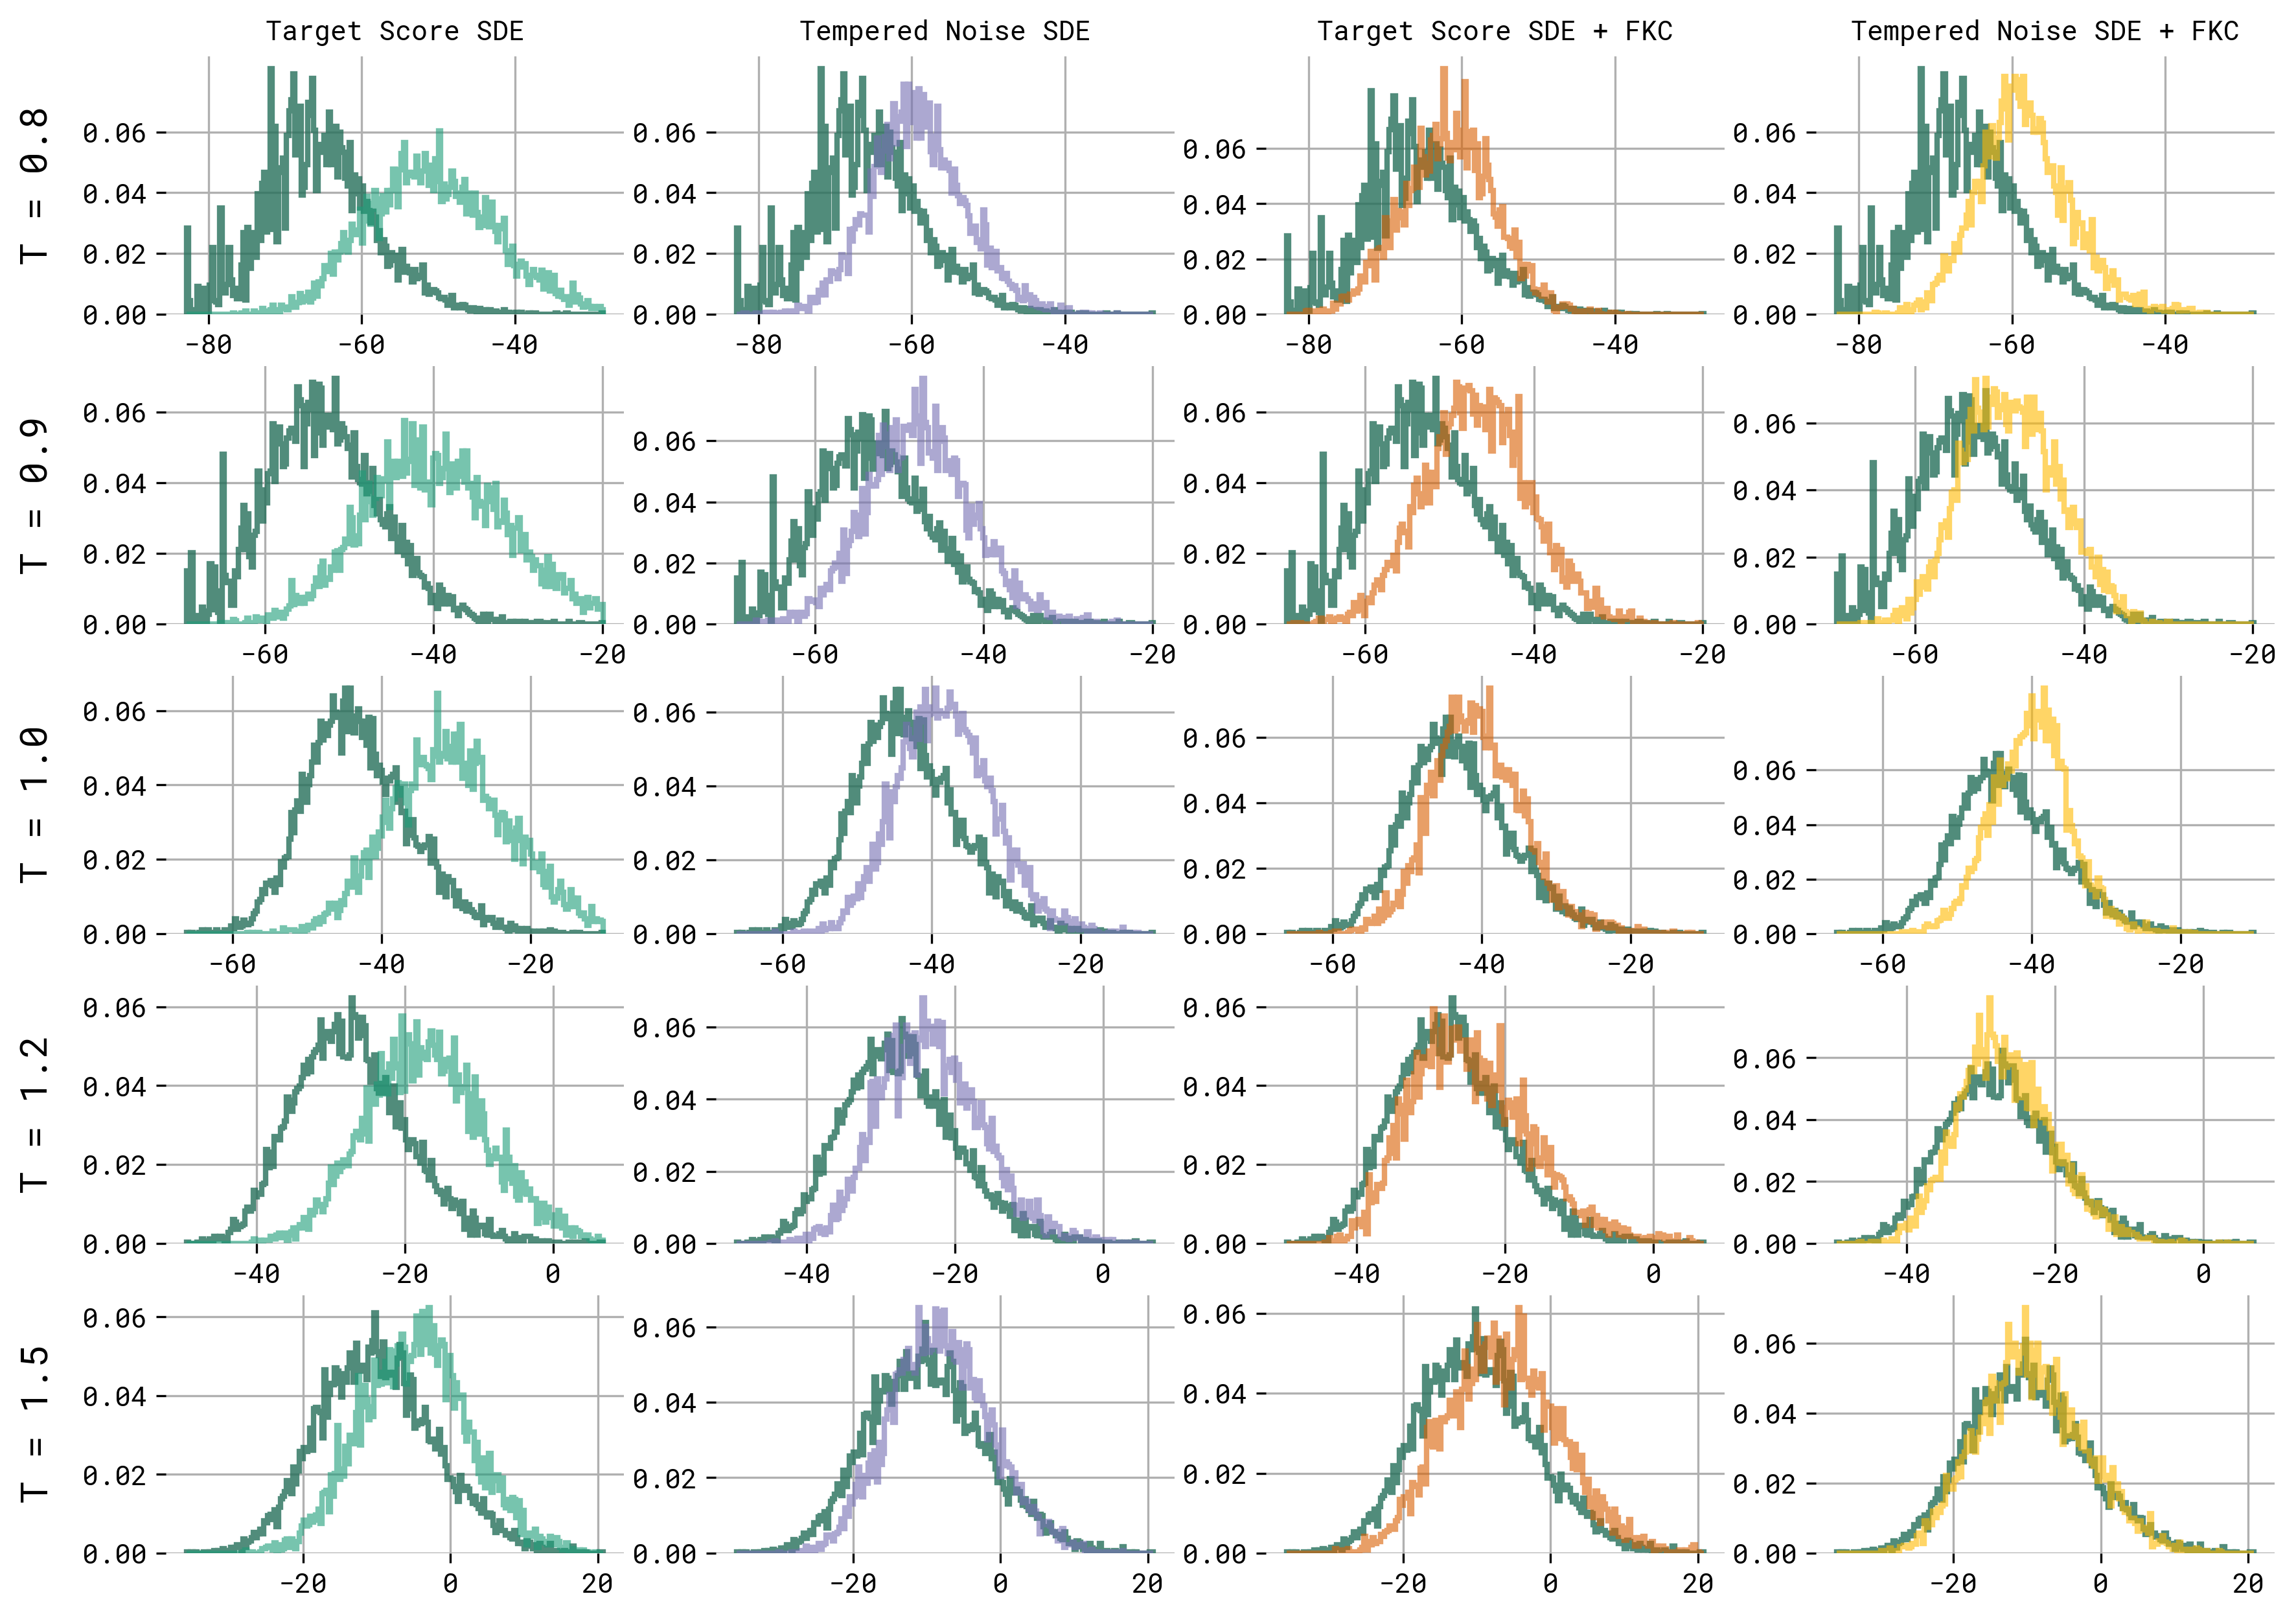

In [297]:
# make a 5 x 4 grid of plots
fig, axs = plt.subplots(5, 4, figsize=(14, 10), dpi=300)
for i, temp in enumerate([0.8, 0.9, 1.0, 1.2, 1.5]):
    target = LennardJonesEnergy(
        dimensionality=dimensionality,
        n_particles=n_particles,
        device=device,
        data_path="../../data/",
        smooth=False,
        temperature=temp,
    )

    test_samples = target.sample_test_set(num_samples)
    test_energy = target(test_samples)

    annealed_samples = {}
    annealed_energy = {}

    sde_types = ["ts", "tn", "ts+fkc", "tn+fkc"]
    for j, sde_type in enumerate(sde_types):
        annealed_samples[sde_type] = load_and_sample_data(sde_type, temp, num_samples)
        annealed_energy[sde_type] = target(annealed_samples[sde_type])

        if i == 0:
            axs[i, j].set_title(leg_labels[sde_type], fontsize=20, fontproperties=prop)

        if j == 0:
            axs[i, j].set_ylabel(
                f"T = {temp}",
                fontsize=14,
                rotation=90,
                labelpad=10,
                fontproperties=prop,
            )

        _, bins, _ = axs[i, j].hist(
            -test_energy.detach().cpu(),
            bins=200,
            density=True,
            alpha=0.8,
            color="#256F5A",
            histtype="step",
            linewidth=2,
            label="MCMC Dataset",
        )

        axs[i, j].hist(
            -annealed_energy[sde_type].detach().cpu(),
            bins=bins,
            density=True,
            alpha=0.6,
            color=colors[sde_type],
            histtype="step",
            linewidth=2,
            label=labels[j],
        )

        axs[i, j].tick_params(labelsize=10)

        axs[i, j].set_yticks(np.arange(0, 0.08, 0.02))

        for label in axs[i, j].get_xticklabels() + axs[i, j].get_yticklabels():
            label.set_fontproperties(prop)
        axs[i, j].tick_params(labelsize=10)

        axs[i, j].spines["top"].set_visible(False)
        axs[i, j].spines["right"].set_visible(False)
        axs[i, j].spines["bottom"].set_visible(False)
        axs[i, j].spines["left"].set_visible(False)
        axs[i, j].xaxis.set_minor_locator(NullLocator())
        axs[i, j].yaxis.set_minor_locator(NullLocator())
        # axis grid true
        axs[i, j].grid(True)


# plt.tight_layout()
plt.savefig("figures/LJ_energies_all_temps.png", bbox_inches="tight")
plt.show()